<font size=25>Laboratory 7 summary</font>

In this lab you will:

* learn what a recurrent neural network is
* what the problem is with vanilla recurrent networks
* train a gated recurrent network (GRU/LSTM) to predict the nationality of a name

# **Part I: Recurrent neural network**

## Motivation


So far we have only addressed problems with one ***fixed input*** x (image, tabular features). We now tackle problems where the input x consists of **sequences of elements**. An important property is that the input sequences have ***variable lengths***.

Examples of *input* sequences:
 - video (sequence of frames)
 - sentences (sequence of words)
 - time series (sequence of features)

The *output* y may consist of:
 - a single element (action recognition)
 - a sequence (machine translation):

|![Sequence problems](https://media5.datahacker.rs/2020/09/48-1024x575-1.jpg)|
|:--:|
| Sequence problems from [source](https://datahacker.rs/003-rnn-architectural-types-of-different-recurrent-neural-networks/) |

**MLP for sequences**

If we wanted to naively process sequences of variable lengths with linear layers, we would need different models to accommodate each length:

|![Sequence varying lengths](https://i.ibb.co/KFYWvcV/sequences.png)|
|:--:|
| Sequence problems from [source](https://i.ibb.co/KFYWvcV/sequences.png) |

**Convolution for sequences**
If we process input sequence with 1D convolutions, we will still get a variable length output. This can be fixed by adding maxpooling-over-time operation for example. However, this solution does not capture long term dependencies (30 is influenced by 10).

<div>
<img src=https://i.ytimg.com/vi/ulKbLD6BRJA/maxresdefault.jpg width="750"/>
<div>

##Recurrent neural networks

We will process the sequence one element at a time. Distinctly from an MLP, we need a 'memory' to store the intermediate results. We call this memory a **hidden state**. 

The first hidden state $h_0$ can be:
 - zero 
 - feature representation of other input data on which our sequence depends (in image-to-text translation, $h_0$ is a feature representation of the image)

<div>
<img src=https://i.ibb.co/sjsY0Pv/mlp-vs-rnn.png width="750"/>
<div>

We apply the same function $f_W$ for all the elements in the sequence. The new hidden state $h_1$ is fed as input in step 2:

<div>
<img src=https://i.ibb.co/DRhMwJ3/rnn-step-2.png width="750"/>
<div>


We keep processing each element until we exhaust the sequence. In the diagram below, the last hidden state $h_{20}$ encapsulates information from the whole sequence. 

When we want to classify sequences $x_1, x_2, ..., x_T$, we can use this **final hidden state** $h_T$ as a feature representation of the entire sequence. We thus feed it to an MLP and compute the loss $L$. 

<div>
<img src=https://i.ibb.co/wJv8FS1/rnn-unrolled.png width="750"/>
<div>


Sometimes, the unrolled RNN is drawn more simply.
<div>
<img src=https://i.ibb.co/W0qZt6p/simplified-RNN.png width="750"/>
<div>


## Optimizing recurrent neural networks

How do we train recurrent neural networks? We use backpropagation just as we trained the previous types of networks. 

Let $W=(W_{xh}, W_{hh})$ be the recurrent parameters. Is the gradient $\frac{\partial L}{\partial W}$ correct?

<div>
<img src=https://i.ibb.co/8NkVG4p/backprop-wrong.png width="750"/>
<div>

The previous answer is wrong, because $h_{20}$ also depends on $h_{18}$, $h_{17}$, ..., $h_{1}$, which were all computed using $W$.


<div>
<img src=https://i.ibb.co/dQJTLFs/vanishing-gradient.png width="750"/>
<div>


## RNNCell (input is a single element)

Let's instantiate a simple recurrent neural cell, called [`RNNCell`](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html?highlight=rnncell#torch.nn.RNNCell). This cell implements the following equation:
$$ h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_{ih} + b_{hh})$$

The cell is applied to ***a single element*** only!

To instantiate it, we need to specify:
 - the input size
 - the size of the hidden state
 - whether to use the bias terms or not
 - what activation function to use (default is `tanh`)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt

model = nn.RNNCell(input_size=100, hidden_size=256, bias=True, nonlinearity='tanh')

Let's plot the module's parameters:

In [ ]:
for n,p in model.named_parameters():
    print(n, ' ', p.size())

weight_ih   torch.Size([256, 100])
weight_hh   torch.Size([256, 256])
bias_ih   torch.Size([256])
bias_hh   torch.Size([256])


Let's now create a random input sequence of 20 elements, each of size 100.

In [ ]:
data = torch.rand(20, 100)

Let's compute the first recurrent step. We will need to initialize the first hidden state.
<div>
<img src=https://i.ibb.co/gStdPF4/rnn-step-1.png width="750"/>
<div>

In [ ]:
# batch_size = 1
h0 = torch.zeros(1, 256)

# batch_size x 100 = 1 x 100
x1 = data[0].unsqueeze(0)
h1 = model(x1, h0)
print("h1 size = ", h1.size())

h1 size =  torch.Size([1, 256])


Let's process the rest of the sequence up to timestep t=20. 
The last hidden state $h_{20}$ will be processed by a linear layer to predict 2 classes.

<div>
<img src=https://i.ibb.co/wJv8FS1/rnn-unrolled.png width="750"/>
<div>

In [ ]:
lin_layer = nn.Linear(256, 2)
loss_fn = nn.CrossEntropyLoss()

hidden_states = [h0, h1]
for t in range(1,20):
    hidden_prev = hidden_states[-1]
    xt = data[t].unsqueeze(0)
    
    # compute new hidden state
    ht = model(xt, hidden_prev)
    
    # add hidden state to list
    hidden_states.append(ht)

# compute scores, then loss
y = lin_layer(hidden_states[-1])
t = torch.tensor([1], dtype=torch.int64)
loss = loss_fn(y, t)
print("loss = ", loss)

# backpropagate
loss.backward()

loss =  tensor(0.6584, grad_fn=<NllLossBackward0>)


## RNN (input is a sequence)

The recurrent cell above was applied sequentially to each *input element*. Fortunately there is a wrapper class called [`RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html?highlight=rnn#torch.nn.RNN) which expects an **input sequence** and recursively calls the cell repeatedly over the timesteps.

To instantiate it, we need to similarly specify:
 - the input size
 - the size of the hidden state
 - whether to use the bias terms or not
 - what activation function to use (default is `tanh`)

We also have additional arguments:
 - `batch_first` - establishes whether inputs have shape `batch x timesteps x D` vs `timesteps x batch x D`
 - `bidirectional` - if True, instantiates a separate model that processes the sequences from **right to left** and concatenates hidden states from both directions
 - `num_layers` - sets the 'height' of the model (`num_layers=1` by default), meaning the number of times the sequence is processed hierarchically
 - `dropout` - applies Dropout on all but the last layer; if `num_layers=1`, no dropout is applied

In [ ]:
# bias=True by default, non-linearity is tanh by default, bidirectional=False
model = nn.RNN(input_size=100, hidden_size=256, batch_first=True)

We also need to initialize the first hidden state. If not provided to the model, it is initialized with a Tensor full `0`s by default. It is good practice to **explicitly initialize the first hidden state** everytime, since there are situations when it shouldn't be filled with `0`s.

In [ ]:
# why do we have two dimension of 1?
h0 = torch.zeros(1, 1, 256)

Let's now feed the input sequence `data` of size 20x100 to the model.


In [ ]:
data = torch.rand(20, 100)
# add dummy batch dimension
# 1 x 20 x 100
data = data.unsqueeze(0)

# process sequence
output, h_t = model(data, h0)

Let's inspect the returned Tensors. `h_t` contains the last hidden state of the sequence.

In [ ]:
print(h_t.size())

torch.Size([1, 1, 256])


The first dimension is 1 because we only have 1 direction (left-to-right) and 1 layer. The second dimension is 1 because `batch_size` is 1.

Let's inspect the output. It is a Tensor holding all the intermediate hidden states.

In [ ]:
print(output.size())

torch.Size([1, 20, 256])


When classifying the whole sequence we can use the **last hidden state**, which contains information about all the elements. This means we do not need the intermediate hidden states. 

However, there are tasks where we want to make predictions **at each step**. In this case, we need to compute losses at each timestep t, based on the hidden state $h_t$.

<div>
<img src=https://i.ibb.co/ygZRZb6/rnn-allsteps-loss.png width="750"/>
<div>


In this case we retrieve them from the `output` Tensor returned by the model.

## Vanilla recurrent neural network for sine wave prediction

### Generate sine data

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt

def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[1:train_len] # as discussed in class, targets are shifted by 1 step

    # batch_size x timesteps x 1, where batch_size=1
    train_x = torch.tensor(xs, dtype=torch.float32).view(1, -1, 1)
    train_y = torch.tensor(ys, dtype=torch.float32)

    return data, time_steps, train_x, train_y

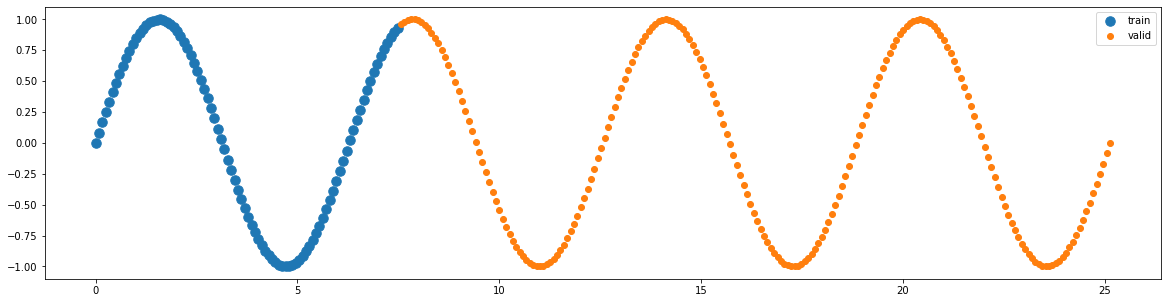

In [ ]:
seq_length = 300 #total sequence length
portion_train = 0.1 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = \
    generate_sinus_wave(train_len = train_len, valid_len = valid_len)

#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

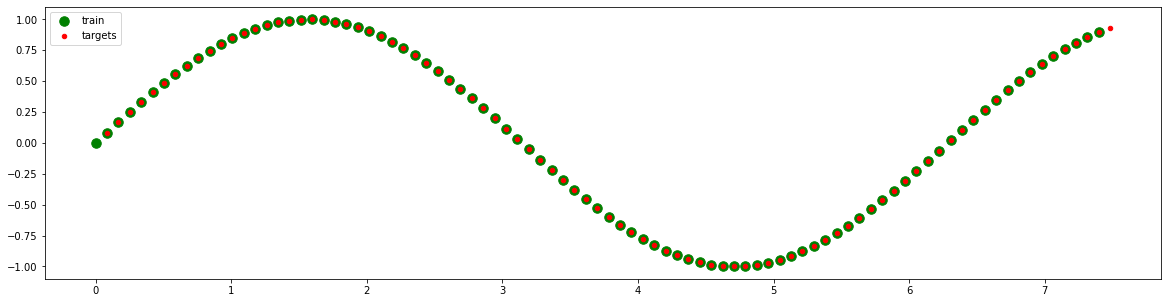

In [ ]:
#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[1:train_len], train_y, s=20, c='r', label='targets')
ax.legend()

### Instantiate model

We will train a recurrent network which predicts a sine wave value $y_t$ at each timestep, based on the true values $x_1$, $x_2$, ..., $x_{t-1}$

<div>
<img src=https://i.ibb.co/ygZRZb6/rnn-allsteps-loss.png width="750"/>
<div>

In [ ]:
HIDDEN_SIZE=10
LR=1e-2

class RNNModel(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # TODO: instantiate RNN here
        self.rnn = ...

        # this layer is applied on top of each hidden state ht in order to 
        # predict a scalar value yt of the sine wave
        self.output_layer = ...
    
    def forward(self, x, h=None):
        # Arguments:
        #   x: time series of shape batch_size x timesteps x 1
        #   h: first hidden state
        
        # TODO: apply recurrent network to sequence x
        # Q: what does Tensor rnn_output contain? what does h_n contain?
        # what shape do they have?
        rnn_output, h_n = ...

        # TODO: apply linear layer to each hidden state
        # output should have shape batch_size x timesteps x 1
        output = ...

        return output, h_n


# TODO: instantiate the RNNModel
model = RNNModel(
    input_size=...,
    hidden_size=HIDDEN_SIZE,
    output_size=...
)

In [ ]:
# TODO: instantiate loss function here
# criterion = 

# this will set-up an optimizer for parameter updates, feel free to ignore this for now!
optimizer = optim.Adam(model.parameters(), lr=LR) 

epochs = 300 # one epoch corresponds to a single pass through the entire training data
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # batch_size x timesteps x 1
    output, _ = model(train_x)

    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.5745945572853088
Epoch 10: loss 0.2455361783504486
Epoch 20: loss 0.07135132700204849
Epoch 30: loss 0.02523892931640148
Epoch 40: loss 0.017011839896440506
Epoch 50: loss 0.01176394522190094
Epoch 60: loss 0.008029099553823471
Epoch 70: loss 0.005973887629806995
Epoch 80: loss 0.004510960541665554
Epoch 90: loss 0.0033145847264677286
Epoch 100: loss 0.0023064538836479187
Epoch 110: loss 0.0015248729614540935
Epoch 120: loss 0.0009586809319444001
Epoch 130: loss 0.0005485126748681068
Epoch 140: loss 0.0002791820443235338
Epoch 150: loss 0.00015738181537017226
Epoch 160: loss 0.00012736208736896515
Epoch 170: loss 0.00012104357301723212
Epoch 180: loss 0.00011525706941029057
Epoch 190: loss 0.00010863664647331461
Epoch 200: loss 0.00010323949391022325
Epoch 210: loss 9.871283691609278e-05
Epoch 220: loss 9.455672989133745e-05
Epoch 230: loss 9.066673374036327e-05
Epoch 240: loss 8.702387276571244e-05
Epoch 250: loss 8.359886851394549e-05
Epoch 260: loss 8.03609800641425e

We will now make predictions

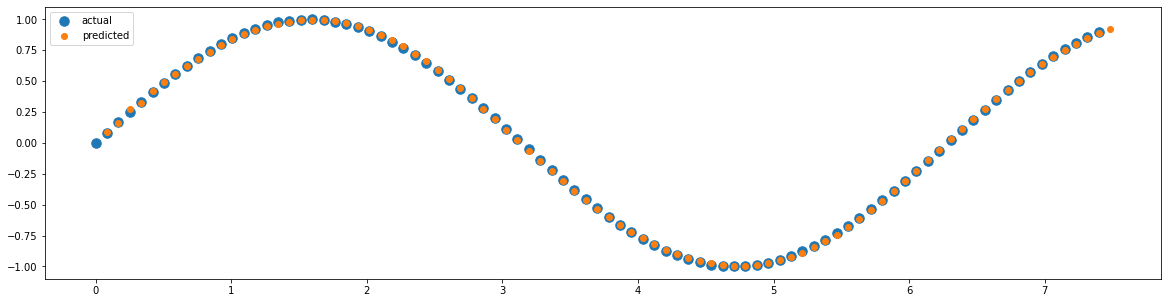

In [ ]:
def make_predictions_train(model, train_x):
    predictions = []
    hidden_prev = None
    # we will go over all points in out training sequence
    # train_x shape: 1 x T x 1
    for i in range(train_x.shape[1]):
        input = train_x[:,i]
        input = input.view(1, 1, 1)
      
        # we will give the current (single) point and the (current) 
        # hidden state as input to our model
        
        # we carry over the previous hidden state
        pred, hidden_prev = model(input, hidden_prev) 
        predictions.append(pred.data.numpy()[0][0])
    return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model, train_x)

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], data[:train_len-1], s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions_train, label='predicted')
ax.legend()

In [ ]:
def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state)
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts

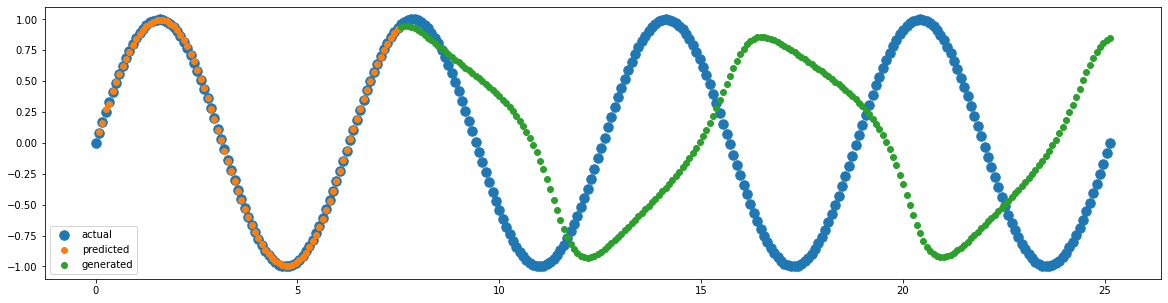

In [ ]:
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

## Vanishing gradients

Vanilla recurrent neural networks face an issue called the [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem. In simple terms, the gradient of the error with respect to $h_t$ becomes smaller as $t$ is smaller. This means that the longer the sequence, the harder it is to capture dependencies between distant elements.

<div>
<img src=https://i.ibb.co/dQJTLFs/vanishing-gradient.png width="750"/>
<div>

### Generate data

We illustrate the vanishing gradient phenomenon by training a model to predict the next sine value $x_t$, based on previous sine values $x_1$,  $x_2$, ...,  $x_{t-1}$.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt

def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[train_len-1] # our target is now only the last point in the training set

    # batch_size x timesteps x 1, where batch_size=1
    train_x = torch.tensor(xs, dtype=torch.float32).view(1, -1, 1)
    train_y = torch.tensor(ys, dtype=torch.float32)

    return data, time_steps, train_x, train_y

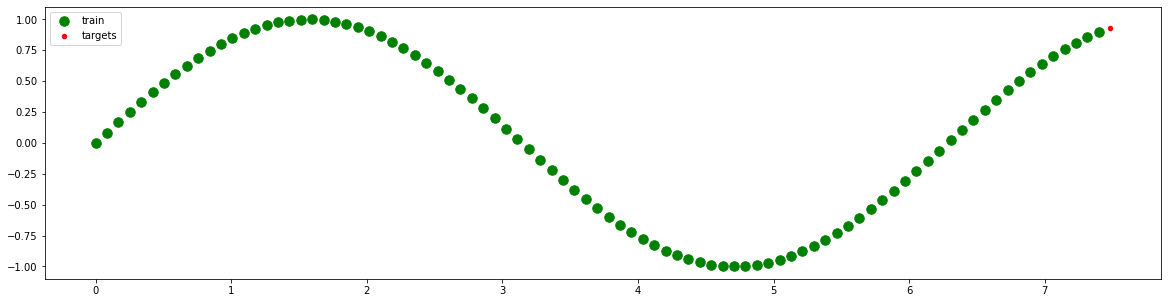

In [ ]:
seq_length = 300 #total sequence length
portion_train = 0.3 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = \
    generate_sinus_wave(train_len = train_len, valid_len = valid_len)

#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[train_len-1], train_y, s=20, c='r', label='targets')
ax.legend()

### Instantiate models

We train a vanilla RNN as well as a gated recurrent unit ([GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit)). The GRU is an improved recurrent model that tackles the vanishing gradient issue by introducing differentiable gates. These gates allow gradients to 'flow' unchanged across timesteps. 

In [ ]:
HIDDEN_SIZE=10
LR=1e-2

class RNNModel(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 cell_type: str = 'rnn'):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cell_type = cell_type

        if cell_type == 'gru':
            self.rnn_cell = nn.GRUCell(
                input_size=input_size, 
                hidden_size=hidden_size
            )
        else:
            self.rnn_cell = nn.RNNCell(
                  input_size=input_size, 
                  hidden_size=hidden_size, 
                  nonlinearity='tanh'
            )

        # this layer is applied on top of each hidden state ht in order to 
        # predict a scalar value yt of the sine wave
        self.output_layer = nn.Linear(
            in_features=hidden_size, 
            out_features=output_size
        )
    
    def forward(self, x, h=None):
        # x has shape: batch_size x timesteps x 1
        # The code below is equivalent to calling the RNN Module once on the 
        # whole sequence. We do this because we want to register the gradient
        # of the loss with respect to the hidden state at each timestep
        
        prev_hidden = None
        rnn_output = []
        for t in range(x.shape[1]):
            ht = self.rnn_cell(x[:,t], prev_hidden)
            ht.retain_grad()
            rnn_output.append(ht)
            prev_hidden = ht

        # we only apply the output layer on the last element
        output = self.output_layer(ht)

        return output, ht, rnn_output

# here we instantiate an RNN and a GRU-based model
model_rnn = RNNModel(input_size=1, 
    hidden_size=HIDDEN_SIZE,
    output_size=1,
    cell_type='rnn'
)
model_gru = RNNModel(input_size=1, 
    hidden_size=HIDDEN_SIZE,
    output_size=1,
    cell_type='gru'
)

We now train both models for 5 epochs and store the gradient of the loss $L$ with respect to each hidden state $h_1$, $h_2$, ..., $h_T$.

In [ ]:
criterion = nn.MSELoss() # we are using mean squared error as loss function here
# this will set-up an optimizer for parameter updates, feel free to ignore this for now!
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=LR) 
optimizer_gru = optim.Adam(model_gru.parameters(), lr=LR) 

epochs = 5 # one epoch corresponds to a single pass through the entire training data
grad_rnn, grad_gru = {}, {}
for epoch in range(epochs):
    optimizer_rnn.zero_grad()
    optimizer_gru.zero_grad()
    
    # output is the scalar 
    rnn_scalar_output, _, rnn_hidden_output = model_rnn(train_x)
    gru_scalar_output, _, gru_hidden_output = model_gru(train_x)

    loss_rnn = criterion(rnn_scalar_output.squeeze(), train_y)
    loss_gru = criterion(gru_scalar_output.squeeze(), train_y)
    loss_rnn.backward()
    loss_gru.backward()

    for t, ht in enumerate(rnn_hidden_output):
        grad_rnn[t] = torch.norm(ht.grad)

    for t, ht in enumerate(gru_hidden_output):
        grad_gru[t] = torch.norm(ht.grad)
    
    optimizer_rnn.step()
    optimizer_gru.step()
    if epoch % 1 == 0:
        print("Epoch {}: loss RNN {}, loss GRU {}".format(epoch, loss_rnn.item(), loss_gru.item()))


Epoch 0: loss RNN 0.7648681402206421, loss GRU 0.43193382024765015
Epoch 1: loss RNN 0.6289367079734802, loss GRU 0.35299035906791687
Epoch 2: loss RNN 0.5109831690788269, loss GRU 0.28298723697662354
Epoch 3: loss RNN 0.40351995825767517, loss GRU 0.2184944748878479
Epoch 4: loss RNN 0.3037375211715698, loss GRU 0.15863624215126038


We not plot the norm of the gradients at each timestep for both RNN and GRU. The gradients with respect to the last hidden states (t>80) have similar norms for both RNN and GRU. However, the more we move towards the sequence beginning (t=0), the RNN gradients become 0, the GRU gradients are consistently larger by several orders of magnitude.

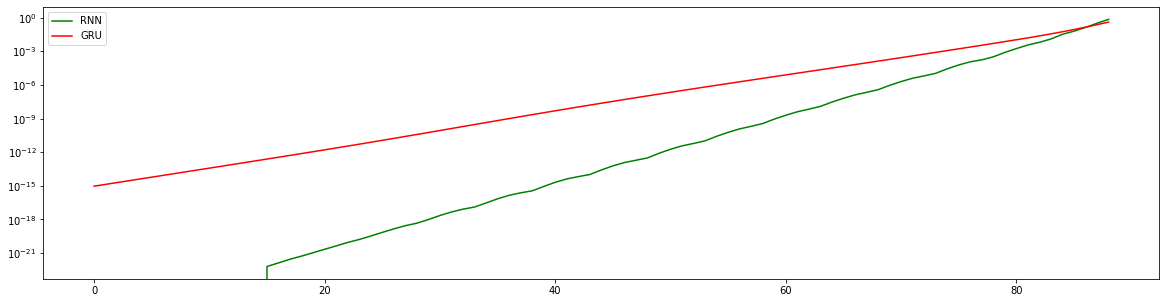

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
timesteps, gradients_rnn = list(grad_rnn.keys()), list(grad_rnn.values())
timesteps, gradients_gru = list(grad_gru.keys()), list(grad_gru.values())

max_index = len(timesteps)
#plt.scatter(timesteps[:max_index], gradients_rnn[:max_index], s=9, c='g', label='RNN')
#plt.scatter(timesteps[:max_index], gradients_gru[:max_index], s=9, c='r', label='GRU')

plt.plot(timesteps[:max_index], gradients_rnn[:max_index], c='g', label='RNN')
plt.plot(timesteps[:max_index], gradients_gru[:max_index], c='r', label='GRU')
ax.set_yscale('log')
ax.legend()

In [ ]:
for t, (grnn, ggru) in enumerate(zip(gradients_rnn, gradients_gru)):
    print(t, "RNN dL/dh{} = {}, GRU DL/dh{} = {}".format(t, grnn, t, ggru))

0 RNN dL/dh0 = 0.0, GRU DL/dh0 = 7.013243048517763e-22
1 RNN dL/dh1 = 0.0, GRU DL/dh1 = 1.084292116260216e-21
2 RNN dL/dh2 = 0.0, GRU DL/dh2 = 1.730079149258593e-21
3 RNN dL/dh3 = 0.0, GRU DL/dh3 = 2.831153075897923e-21
4 RNN dL/dh4 = 0.0, GRU DL/dh4 = 4.7279503160578654e-21
5 RNN dL/dh5 = 0.0, GRU DL/dh5 = 8.020125115051081e-21
6 RNN dL/dh6 = 0.0, GRU DL/dh6 = 1.377268159921722e-20
7 RNN dL/dh7 = 0.0, GRU DL/dh7 = 2.3887887184803196e-20
8 RNN dL/dh8 = 0.0, GRU DL/dh8 = 4.177924161000259e-20
9 RNN dL/dh9 = 0.0, GRU DL/dh9 = 7.360847626562113e-20
10 RNN dL/dh10 = 0.0, GRU DL/dh10 = 1.3056046890065943e-19
11 RNN dL/dh11 = 0.0, GRU DL/dh11 = 2.330606708274415e-19
12 RNN dL/dh12 = 0.0, GRU DL/dh12 = 4.186447158613367e-19
13 RNN dL/dh13 = 0.0, GRU DL/dh13 = 7.567496989117407e-19
14 RNN dL/dh14 = 0.0, GRU DL/dh14 = 1.3767153641656408e-18
15 RNN dL/dh15 = 0.0, GRU DL/dh15 = 2.521159032711851e-18
16 RNN dL/dh16 = 0.0, GRU DL/dh16 = 4.64837247151471e-18
17 RNN dL/dh17 = 0.0, GRU DL/dh17 = 8.629

## Gated recurrent units ([GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit)) for sine wave prediction

Gated recurrent units are a modification of the vanilla RNN which tackle the vanishing gradient issue. This allows for long term dependencies to be better captured.

GRU equations:

  $z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)$

  $r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)$

  $\hat{h_t} = \phi(W_h x_t + U_h h_{t-1} + b_h)$

  $h_t = (1-z_t) \odot h_{t-1} + z_t \odot \hat{h_t}$


Let's say $z_t=[0, 0,...,0]$. What is the value of $h_t$? What is $\frac{\partial h_t}{\partial h_{t-1}}$?

<div>
<img src=https://i.ibb.co/P9wgSFn/gru.png width="750"/>
<div>


### Generate sine wave
We again generate our sine wave dataset.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from typing import List
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, Sampler

%matplotlib inline
import matplotlib.pyplot as plt

def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[1:train_len] # as discussed in class, targets are shifted by 1 step

    # batch_size x timesteps x 1, where batch_size=1
    train_x = torch.tensor(xs, dtype=torch.float32).view(1, -1, 1)
    train_y = torch.tensor(ys, dtype=torch.float32)

    return data, time_steps, train_x, train_y

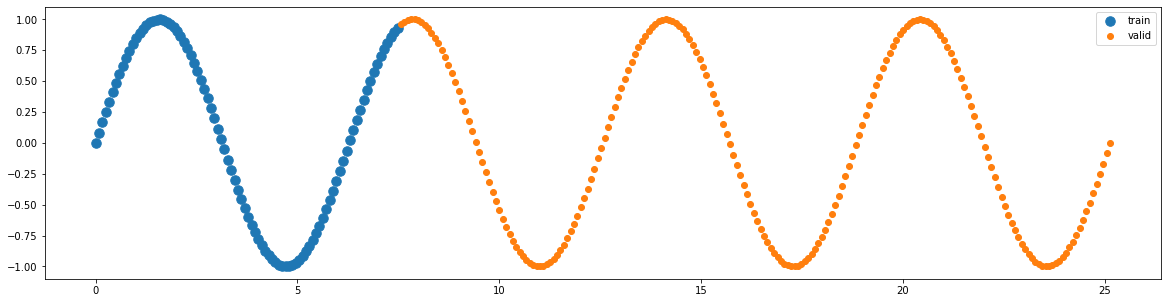

In [ ]:
seq_length = 300 #total sequence length
portion_train = 0.3 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = \
    generate_sinus_wave(train_len = train_len, valid_len = valid_len)

#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

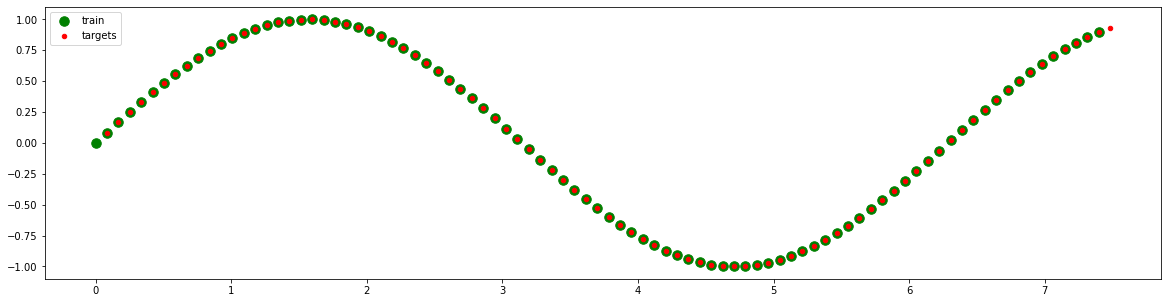

In [ ]:
#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[1:train_len], train_y, s=20, c='r', label='targets')
ax.legend()

### Instantiate model

We will train a recurrent network which predicts a sine wave value $y_t$ at each timestep, based on the true values $x_1$, $x_2$, ..., $x_{t-1}$


In [ ]:
HIDDEN_SIZE=10
LR=1e-2

class RNNModel(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # TODO: instantiate GRU network in Pytorch
        self.rnn = ...

        # TODO: this linear layer is applied on top of each hidden state ht in order to 
        # predict a scalar value yt of the sine wave
        self.output_layer = ...
    
    def forward(self, x, h=None):
        # x has shape: batch_size x timesteps x 1
        # TODO: process sequence x
        rnn_output, h_n = ...

        # TODO: apply output layer
        # batch_size x timesteps x 1
        output = ...

        return output, h_n


# TODO: instantiate an RNNModel based on the GRU
model = RNNModel(
    input_size=...,
    hidden_size=HIDDEN_SIZE,
    output_size=...
)

In [ ]:
# TODO: instantiate loss function

# this will set-up an optimizer for parameter updates, feel free to ignore this for now!
optimizer = optim.Adam(model.parameters(), lr=LR) 

epochs = 300 # one epoch corresponds to a single pass through the entire training data
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # batch_size x timesteps x 1
    output, _ = model(train_x)

    #print("output size = ", output.size())
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.556985080242157
Epoch 10: loss 0.1641015112400055
Epoch 20: loss 0.04705270379781723
Epoch 30: loss 0.01173385325819254
Epoch 40: loss 0.0040426659397780895
Epoch 50: loss 0.0020367035176604986
Epoch 60: loss 0.0011961087584495544
Epoch 70: loss 0.0008245438802987337
Epoch 80: loss 0.0005447352887131274
Epoch 90: loss 0.0003858723503071815
Epoch 100: loss 0.00029839115450158715
Epoch 110: loss 0.0002431838947813958
Epoch 120: loss 0.00020625264733098447
Epoch 130: loss 0.00017715738795232028
Epoch 140: loss 0.00015324003470595926
Epoch 150: loss 0.0001333726104348898
Epoch 160: loss 0.00011707682278938591
Epoch 170: loss 0.00010348812793381512
Epoch 180: loss 9.208724077325314e-05
Epoch 190: loss 8.245847129728645e-05
Epoch 200: loss 7.426647061947733e-05
Epoch 210: loss 6.72452588332817e-05
Epoch 220: loss 6.118101009633392e-05
Epoch 230: loss 5.5904067266965285e-05
Epoch 240: loss 5.1279825129313394e-05
Epoch 250: loss 4.719988282886334e-05
Epoch 260: loss 4.357787111

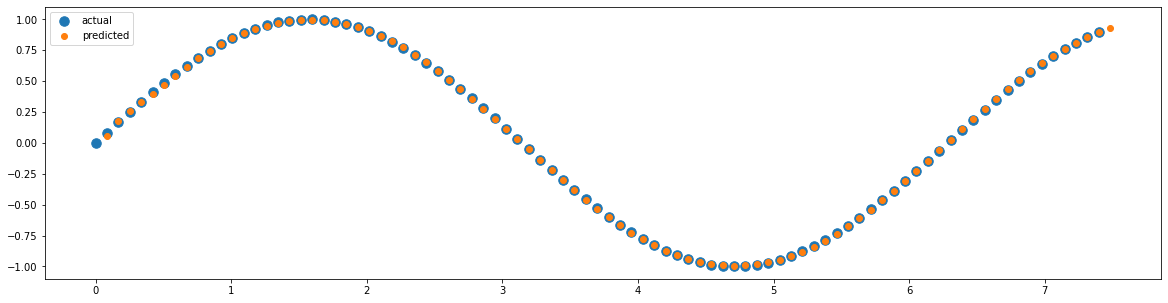

In [ ]:
def make_predictions_train(model, train_x):
    predictions = []
    hidden_prev = None
    # we will go over all points in out training sequence
    # train_x shape: 1 x T x 1
    for i in range(train_x.shape[1]):
        input = train_x[:,i]
        input = input.view(1, 1, 1)
      
        # we will give the current (single) point and the (current) 
        # hidden state as input to our model
        
        # we carry over the previous hidden state
        pred, hidden_prev = model(input, hidden_prev) 
        predictions.append(pred.data.numpy()[0][0])
    return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model, train_x)

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], data[:train_len-1], s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions_train, label='predicted')
ax.legend()

In [ ]:
def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state)
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts

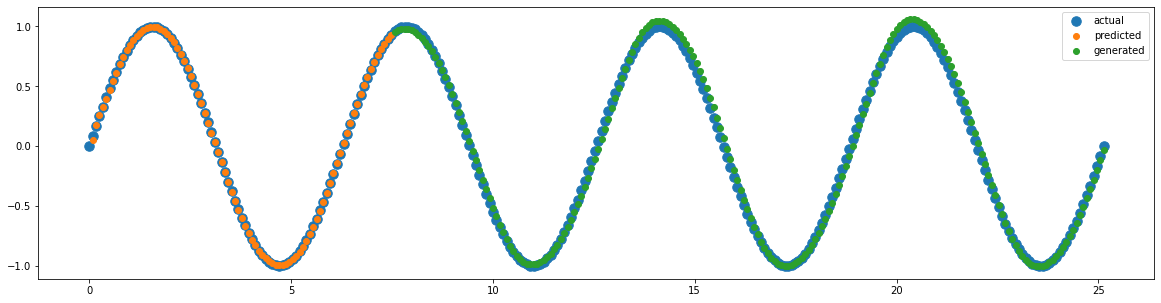

In [ ]:
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

## TODO: Classify names with RNN ([source](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html))

Given a name, predict its nationality:
 - Klineberg => Czech
 - Bonnay => French

There are 18 nationalities: Arabic, Chinese, Czech, Dutch, English, French, German, Greek, Irish, Italian, Japanese, Korean, Polish, Portuguese, Russian, Scottish, Spanish, and Vietnamese.

Training details:
 - what is the input and output to your RNN?
 - how do you represent your input?
 - what loss function do you use?
 

In [ ]:
import zipfile
import os
from io import open
import glob
from typing import List
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, Sampler
import unicodedata
import random
import string
import torch
from __future__ import unicode_literals, print_function, division

!wget --no-check-certificate \
https://download.pytorch.org/tutorial/data.zip \
-O /tmp/data.zip

# Extract the data
local_zip = '/tmp/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# set up folders
base_dir = '/tmp/data/names'

--2022-03-30 09:21:54--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.156.120.2, 108.156.120.107, 108.156.120.103, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.156.120.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip       100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2022-03-30 09:21:54 (40.7 MB/s) - ‘/tmp/data.zip’ saved [2882130/2882130]



In [ ]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('/tmp/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)

# this maps the label name (Arabic, Chinese etc.) to a label index (0, 1, ..., 17)
category_to_idx = {k:all_categories.index(k) for k in all_categories}

# this maps a label index (0, 1, ..., 17) to a label name (Arabic, Chinese etc.)
idx_to_category = {v:k for k, v in category_to_idx.items()}

Slusarski


In [ ]:
print("Labels and their label ids: ", category_to_idx)
print("Label ids and their categories: ", idx_to_category)

Labels and their label ids:  {'Irish': 0, 'Portuguese': 1, 'Japanese': 2, 'English': 3, 'Czech': 4, 'Vietnamese': 5, 'Dutch': 6, 'Chinese': 7, 'Italian': 8, 'Greek': 9, 'Arabic': 10, 'Polish': 11, 'French': 12, 'German': 13, 'Korean': 14, 'Russian': 15, 'Spanish': 16, 'Scottish': 17}
Label ids and their categories:  {0: 'Irish', 1: 'Portuguese', 2: 'Japanese', 3: 'English', 4: 'Czech', 5: 'Vietnamese', 6: 'Dutch', 7: 'Chinese', 8: 'Italian', 9: 'Greek', 10: 'Arabic', 11: 'Polish', 12: 'French', 13: 'German', 14: 'Korean', 15: 'Russian', 16: 'Spanish', 17: 'Scottish'}


Let's print the 18 labels and some examples

In [ ]:
print("Labels: ", list(category_lines.keys()))
print("Some Irish names: ", category_lines['Irish'][:10])

Labels:  ['Irish', 'Portuguese', 'Japanese', 'English', 'Czech', 'Vietnamese', 'Dutch', 'Chinese', 'Italian', 'Greek', 'Arabic', 'Polish', 'French', 'German', 'Korean', 'Russian', 'Spanish', 'Scottish']
Some Irish names:  ['Adam', 'Ahearn', 'Aodh', 'Aodha', 'Aonghuis', 'Aonghus', 'Bhrighde', 'Bradach', 'Bradan', 'Braden']


Q: How do we represent each name? 
A: As a sequence of letters

But how do we represent a letter? We will use a one-hot encoding scheme, where each letter is represented using a one-hot vector.

In [ ]:
print(len(all_letters), 'characters: ', all_letters)

57 characters:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


Each character is represented with a vector of size 57 of 0s and 1:

a = [1, 0, 0, ..., 0]

b = [0, 1, 0, ..., 0]

c = [0, 0, 1, ..., 0]

...

; = [0, 0, 0, ..., 1]

In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a name into a <name_length x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())
print(lineToTensor('Jones'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 57])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0

### We will write a Dataset for retrieving these examples

For each nationality, we use 80% of its names for training and 20% of its names for validation. We put all the names and their corresponding labels in lists.

In [ ]:
train_names, train_labels = [], []
val_names, val_labels = [], []
for cat, names in category_lines.items():
    # TODO:
    # for each nationality:
    # - pick 80% of the names and add them and their labels
    #   to the train_names and train_labels lists
    # - add the other 20% of the names to val_names and 
    #   val_Labels lists

In [ ]:
class NameDataset(Dataset):
    def __init__(self, names: List[str], labels: List[int]):
        # names: list of names
        # labels: list of labels (stored as numbers)

        # TODO: populate names_tensor list
        # this list will store one Tensor for each name
        # what size does each Tensor have?
        self.names_tensor = []
        # ...

        self.labels = torch.tensor(labels, dtype=torch.int64)

    def __getitem__(self, index) -> (torch.Tensor, torch.Tensor):
        # TODO

    def __len__(self):
        return len(self.labels)

In [ ]:
# initialize datasets and dataloaders
# for now we use batch_size=1, because sequences in a batch may have different lengths
train_dataset = NameDataset(train_names, train_labels)
val_dataset = NameDataset(val_names, val_labels)
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=1,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=1 #
)

Write the RNNModel below

In [ ]:
HIDDEN_SIZE=10
LR=1e-2

class RNNModel(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # TODO: instantiate recurrent network below (GRU/RNN)
        self.rnn = 

        # TODO: this layer is applied on top of the last hidden state in order
        # to predict the nationality
        self.output_layer = ...
    
    def forward(self, x):
        # x has shape: batch_size x timesteps x 57 (batch_size=1)
        
        # TODO: initialize first hidden state
        # h has shape: batch_size x D X hidden_size (batch_size=1, D=1)
        # What is D?
        h0 = ...
        
        # TODO: feed sequence x to RNN
        # what size does h_n have?
        rnn_output, h_n = ..

        # TODO: apply linear layer to get the label scores
        # batch_size x 18 (batch_size=1)
        output_scores = ...

        return output_scores


# here we instantiate an RNN
model = RNNModel(
    input_size=57,
    hidden_size=HIDDEN_SIZE,
    output_size=18
)

TODOs: 
 - write the train and evaluation loops
 - plot the train/val loss curves and the train/val accuracy curves
 - plot the confusion matrix for the best model on the validation set and inspect the errors made by the model
 - (bonus) modify the batch_size to be larger than 1? What happens when you load a batch of examples? Modify `NameDataset` to fix the problem and retrain the model